ここではtrainデータ全体からランダムにデータを取る。  
データ数を増やすことで性能向上することを示すには全体の訓練データからランダムにデータを取ってくる必要があると考えた。

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertModel, BertConfig
import seaborn as sns
from transformers import TrainingArguments, Trainer
from sklearn.model_selection import train_test_split

#import utils

# For reproducibility
np.random.seed(42)
torch.manual_seed(42) # 乱数生成シード
cudnn.benchmark = True

# Grab a GPU if there is one
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using {} device: {}".format(device, torch.cuda.current_device()))
else:
    device = torch.device("cpu")
    print("Using {}".format(device))

Using cuda device: 0


In [2]:
fold = "../../train_raw_npy/"
acc_x = np.loadtxt("../../train_raw/Acc_x.txt")
label = np.load(f"{fold}sampled_label.npy")

print(acc_x.shape)
print(label.shape)

(196072, 500)
(196072,)


In [4]:
# ビンの数を設定
num_bins = 30000  

# ビンの境界を等頻度で設定
bins = np.percentile(acc_x, np.linspace(0, 100, num_bins + 1))

# データをビンに分割
discrete_data = np.digitize(acc_x, bins) - 1  # ビンのインデックスを取得し、0から始まるように調整

# 予約トークンを避けるためにシフト
discrete_data += 104

# 最大インデックスを確認
max_index = discrete_data.max()
print(f"Max index after shifting: {max_index}")

# vocab_sizeを確認（シフト後の最大値を考慮）
vocab_size = max_index + 1
print(f"Vocab size: {vocab_size}")

# 確認のための一部データ
print("Sample discrete data:", discrete_data[:10])
print("Discrete data range:", np.min(discrete_data), "to", np.max(discrete_data))

"""# 分布の視覚化
plt.figure(figsize=(12, 6))
sns.histplot(discrete_data.flatten(), bins=num_bins, kde=False)
plt.title(f"Distribution of Discretized Accelerometer X-axis Data ({num_bins} bins, equal-frequency)")
plt.xlabel("Discrete Value")
plt.ylabel("Frequency")
plt.show()"""

# 離散化されたデータを保存
#np.save("train_token_ids_rebinned.npy", discrete_data)

Max index after shifting: 30104
Vocab size: 30105
Sample discrete data: [[24029 24034 24075 ...  6255  7731  8392]
 [ 8839  8946  7772 ...  9095  9134  8994]
 [ 8474  7847  7012 ... 25182 25115 25278]
 ...
 [16043 14565 19002 ... 26111 21273  9221]
 [ 3849 12370 16115 ... 23046 24751 23873]
 [12795 12362 21437 ...  7500 12527 17853]]
Discrete data range: 104 to 30104


'# 分布の視覚化\nplt.figure(figsize=(12, 6))\nsns.histplot(discrete_data.flatten(), bins=num_bins, kde=False)\nplt.title(f"Distribution of Discretized Accelerometer X-axis Data ({num_bins} bins, equal-frequency)")\nplt.xlabel("Discrete Value")\nplt.ylabel("Frequency")\nplt.show()'

In [6]:
discrete_data.shape

(196072, 500)

In [16]:
#説明変数
discrete_data
#目的変数
label

# ランダム9万データを使う  
size = 90000
sample_indices = np.random.choice(discrete_data.shape[0], size=size, replace=False)
X_30000 = discrete_data[sample_indices, :]
label_30000 = label[sample_indices]
print(X_30000.shape)
print(label_30000.shape)

(90000, 500)
(90000,)


In [17]:
print(X_30000.dtype)
print(label_30000.dtype)
X_30000 =X_30000.astype(np.int32)
label_30000 = label_30000.astype(np.int32)
print(X_30000.dtype)
print(label_30000.dtype)

int64
float64
int32
int32


In [18]:
# ランダムサンプリング
train_x, test_x, train_label, test_label = train_test_split(X_30000, label_30000, test_size=0.2,random_state=40)

# 結果の確認
print(f"Train data shape: {train_x.shape}")
print(f"Test data shape: {test_x.shape}")
print(f"Train label shape: {train_label.shape}")
print(f"Test label shape: {test_label.shape}")
print(pd.Series(train_label).value_counts())
print(pd.Series(test_label).value_counts())

Train data shape: (72000, 500)
Test data shape: (18000, 500)
Train label shape: (72000,)
Test label shape: (18000,)
5    11695
7    11573
6    10313
1     9088
2     8968
4     8672
8     8650
3     3041
Name: count, dtype: int64
5    2951
7    2924
6    2639
2    2223
8    2202
1    2195
4    2145
3     721
Name: count, dtype: int64


In [10]:
import torch
from torch.utils.data import Dataset, DataLoader

class SensorDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_ids = torch.tensor(self.data[idx], dtype=torch.long)
        labels = torch.tensor(self.labels[idx], dtype=torch.long)

        # [CLS] と [SEP] トークンを追加
        input_ids = torch.cat([torch.tensor([101]), input_ids, torch.tensor([102])])

        attention_mask = torch.ones(input_ids.shape, dtype=torch.long)

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels
        }

In [19]:
# ラベルを0~7クラス分類とする
print(train_label)
train_label -=1
print(train_label)
print(test_label)
test_label -=1
print(test_label)

[8 8 7 ... 8 8 5]
[7 7 6 ... 7 7 4]
[2 6 7 ... 2 8 1]
[1 5 6 ... 1 7 0]


In [20]:
# データセットとデータローダの作成
train_dataset = SensorDataset(train_x, train_label)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
eval_dataset = SensorDataset(test_x, test_label)
eval_dataloader = DataLoader(eval_dataset)

In [21]:
#DistilBERT
from transformers import DistilBertForSequenceClassification, DistilBertConfig

config = DistilBertConfig(
    vocab_size=vocab_size,
    num_labels=8,
)
model = DistilBertForSequenceClassification(config)

print(model)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30105, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [22]:
# トレーニング設定
training_args = TrainingArguments(
    output_dir="./results_distilBERT",
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=16,
    save_steps=0,
    save_total_limit=None,
    #logging_dir = "./logs_distilBERT",
    evaluation_strategy="steps",
    eval_steps=1_000,
    logging_steps=100,
)

# トレーナーの定義
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)

# トレーニングの実行
trainer.train()

c:\Users\kaiha\anaconda3\envs\labo_Okita\lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/13500 [00:00<?, ?it/s]

{'loss': 2.071, 'grad_norm': 4.613680839538574, 'learning_rate': 4.962962962962963e-05, 'epoch': 0.02}
{'loss': 2.0467, 'grad_norm': 4.197099208831787, 'learning_rate': 4.925925925925926e-05, 'epoch': 0.04}
{'loss': 2.0003, 'grad_norm': 4.159625053405762, 'learning_rate': 4.888888888888889e-05, 'epoch': 0.07}
{'loss': 1.8375, 'grad_norm': 4.48900842666626, 'learning_rate': 4.851851851851852e-05, 'epoch': 0.09}
{'loss': 1.7597, 'grad_norm': 5.961471080780029, 'learning_rate': 4.814814814814815e-05, 'epoch': 0.11}
{'loss': 1.6741, 'grad_norm': 5.165743827819824, 'learning_rate': 4.7777777777777784e-05, 'epoch': 0.13}
{'loss': 1.6744, 'grad_norm': 5.50162410736084, 'learning_rate': 4.740740740740741e-05, 'epoch': 0.16}
{'loss': 1.5848, 'grad_norm': 5.384620666503906, 'learning_rate': 4.703703703703704e-05, 'epoch': 0.18}
{'loss': 1.6238, 'grad_norm': 6.086410045623779, 'learning_rate': 4.666666666666667e-05, 'epoch': 0.2}
{'loss': 1.5841, 'grad_norm': 7.636211395263672, 'learning_rate': 4

  0%|          | 0/2250 [00:00<?, ?it/s]

{'eval_loss': 1.6544111967086792, 'eval_runtime': 77.6457, 'eval_samples_per_second': 231.822, 'eval_steps_per_second': 28.978, 'epoch': 0.22}
{'loss': 1.5385, 'grad_norm': 6.409165382385254, 'learning_rate': 4.592592592592593e-05, 'epoch': 0.24}
{'loss': 1.5743, 'grad_norm': 5.091908931732178, 'learning_rate': 4.555555555555556e-05, 'epoch': 0.27}
{'loss': 1.5606, 'grad_norm': 5.8633527755737305, 'learning_rate': 4.518518518518519e-05, 'epoch': 0.29}
{'loss': 1.5507, 'grad_norm': 5.243459224700928, 'learning_rate': 4.481481481481482e-05, 'epoch': 0.31}
{'loss': 1.523, 'grad_norm': 6.368307590484619, 'learning_rate': 4.4444444444444447e-05, 'epoch': 0.33}
{'loss': 1.5269, 'grad_norm': 4.4953999519348145, 'learning_rate': 4.4074074074074076e-05, 'epoch': 0.36}
{'loss': 1.5388, 'grad_norm': 7.53644323348999, 'learning_rate': 4.3703703703703705e-05, 'epoch': 0.38}
{'loss': 1.5287, 'grad_norm': 5.409287929534912, 'learning_rate': 4.3333333333333334e-05, 'epoch': 0.4}
{'loss': 1.5382, 'grad

  0%|          | 0/2250 [00:00<?, ?it/s]

{'eval_loss': 1.501268744468689, 'eval_runtime': 77.6742, 'eval_samples_per_second': 231.737, 'eval_steps_per_second': 28.967, 'epoch': 0.44}
{'loss': 1.5162, 'grad_norm': 5.308568477630615, 'learning_rate': 4.222222222222222e-05, 'epoch': 0.47}
{'loss': 1.511, 'grad_norm': 5.515097141265869, 'learning_rate': 4.185185185185185e-05, 'epoch': 0.49}
{'loss': 1.4797, 'grad_norm': 6.488932132720947, 'learning_rate': 4.148148148148148e-05, 'epoch': 0.51}
{'loss': 1.5005, 'grad_norm': 7.260879993438721, 'learning_rate': 4.111111111111111e-05, 'epoch': 0.53}
{'loss': 1.5251, 'grad_norm': 4.085023403167725, 'learning_rate': 4.074074074074074e-05, 'epoch': 0.56}
{'loss': 1.5158, 'grad_norm': 4.809276103973389, 'learning_rate': 4.0370370370370374e-05, 'epoch': 0.58}
{'loss': 1.485, 'grad_norm': 5.25411319732666, 'learning_rate': 4e-05, 'epoch': 0.6}
{'loss': 1.4623, 'grad_norm': 6.034760475158691, 'learning_rate': 3.962962962962963e-05, 'epoch': 0.62}
{'loss': 1.5066, 'grad_norm': 4.3189978599548

  0%|          | 0/2250 [00:00<?, ?it/s]

{'eval_loss': 1.4923814535140991, 'eval_runtime': 77.6302, 'eval_samples_per_second': 231.868, 'eval_steps_per_second': 28.984, 'epoch': 0.67}
{'loss': 1.4766, 'grad_norm': 5.044919013977051, 'learning_rate': 3.851851851851852e-05, 'epoch': 0.69}
{'loss': 1.4894, 'grad_norm': 4.982274532318115, 'learning_rate': 3.814814814814815e-05, 'epoch': 0.71}
{'loss': 1.4754, 'grad_norm': 5.8037848472595215, 'learning_rate': 3.777777777777778e-05, 'epoch': 0.73}
{'loss': 1.4672, 'grad_norm': 5.422122001647949, 'learning_rate': 3.740740740740741e-05, 'epoch': 0.76}
{'loss': 1.4698, 'grad_norm': 6.601980686187744, 'learning_rate': 3.7037037037037037e-05, 'epoch': 0.78}
{'loss': 1.4404, 'grad_norm': 5.108330249786377, 'learning_rate': 3.6666666666666666e-05, 'epoch': 0.8}
{'loss': 1.4536, 'grad_norm': 5.064888954162598, 'learning_rate': 3.62962962962963e-05, 'epoch': 0.82}
{'loss': 1.463, 'grad_norm': 5.137805461883545, 'learning_rate': 3.592592592592593e-05, 'epoch': 0.84}
{'loss': 1.4126, 'grad_no

  0%|          | 0/2250 [00:00<?, ?it/s]

{'eval_loss': 1.4258750677108765, 'eval_runtime': 77.9992, 'eval_samples_per_second': 230.772, 'eval_steps_per_second': 28.846, 'epoch': 0.89}
{'loss': 1.4369, 'grad_norm': 6.300343990325928, 'learning_rate': 3.481481481481482e-05, 'epoch': 0.91}
{'loss': 1.4298, 'grad_norm': 4.310847282409668, 'learning_rate': 3.444444444444445e-05, 'epoch': 0.93}
{'loss': 1.4348, 'grad_norm': 4.380254745483398, 'learning_rate': 3.4074074074074077e-05, 'epoch': 0.96}
{'loss': 1.4425, 'grad_norm': 4.5498151779174805, 'learning_rate': 3.3703703703703706e-05, 'epoch': 0.98}
{'loss': 1.4147, 'grad_norm': 5.878993988037109, 'learning_rate': 3.3333333333333335e-05, 'epoch': 1.0}
{'loss': 1.3409, 'grad_norm': 4.837380409240723, 'learning_rate': 3.2962962962962964e-05, 'epoch': 1.02}
{'loss': 1.343, 'grad_norm': 5.673798561096191, 'learning_rate': 3.25925925925926e-05, 'epoch': 1.04}
{'loss': 1.2933, 'grad_norm': 5.364459991455078, 'learning_rate': 3.222222222222223e-05, 'epoch': 1.07}
{'loss': 1.3382, 'grad_

  0%|          | 0/2250 [00:00<?, ?it/s]

{'eval_loss': 1.4249873161315918, 'eval_runtime': 77.8074, 'eval_samples_per_second': 231.34, 'eval_steps_per_second': 28.918, 'epoch': 1.11}
{'loss': 1.3282, 'grad_norm': 5.648482799530029, 'learning_rate': 3.111111111111111e-05, 'epoch': 1.13}
{'loss': 1.3085, 'grad_norm': 6.054837226867676, 'learning_rate': 3.074074074074074e-05, 'epoch': 1.16}
{'loss': 1.3339, 'grad_norm': 5.788925647735596, 'learning_rate': 3.037037037037037e-05, 'epoch': 1.18}
{'loss': 1.3575, 'grad_norm': 5.903901100158691, 'learning_rate': 3e-05, 'epoch': 1.2}
{'loss': 1.2824, 'grad_norm': 6.849405288696289, 'learning_rate': 2.962962962962963e-05, 'epoch': 1.22}
{'loss': 1.326, 'grad_norm': 5.583255767822266, 'learning_rate': 2.925925925925926e-05, 'epoch': 1.24}
{'loss': 1.3169, 'grad_norm': 9.44035530090332, 'learning_rate': 2.8888888888888888e-05, 'epoch': 1.27}
{'loss': 1.315, 'grad_norm': 4.916123390197754, 'learning_rate': 2.851851851851852e-05, 'epoch': 1.29}
{'loss': 1.3048, 'grad_norm': 6.6500277519226

  0%|          | 0/2250 [00:00<?, ?it/s]

{'eval_loss': 1.4181965589523315, 'eval_runtime': 77.5872, 'eval_samples_per_second': 231.997, 'eval_steps_per_second': 29.0, 'epoch': 1.33}
{'loss': 1.323, 'grad_norm': 6.295002460479736, 'learning_rate': 2.7407407407407408e-05, 'epoch': 1.36}
{'loss': 1.3141, 'grad_norm': 6.546736240386963, 'learning_rate': 2.7037037037037037e-05, 'epoch': 1.38}
{'loss': 1.2669, 'grad_norm': 4.872349739074707, 'learning_rate': 2.6666666666666667e-05, 'epoch': 1.4}
{'loss': 1.292, 'grad_norm': 5.854955196380615, 'learning_rate': 2.6296296296296296e-05, 'epoch': 1.42}
{'loss': 1.2947, 'grad_norm': 7.416342735290527, 'learning_rate': 2.5925925925925925e-05, 'epoch': 1.44}
{'loss': 1.3054, 'grad_norm': 7.742646217346191, 'learning_rate': 2.5555555555555554e-05, 'epoch': 1.47}
{'loss': 1.2778, 'grad_norm': 4.703642845153809, 'learning_rate': 2.5185185185185183e-05, 'epoch': 1.49}
{'loss': 1.3074, 'grad_norm': 4.682825565338135, 'learning_rate': 2.4814814814814816e-05, 'epoch': 1.51}
{'loss': 1.3179, 'grad

  0%|          | 0/2250 [00:00<?, ?it/s]

{'eval_loss': 1.4151461124420166, 'eval_runtime': 77.8817, 'eval_samples_per_second': 231.12, 'eval_steps_per_second': 28.89, 'epoch': 1.56}
{'loss': 1.2705, 'grad_norm': 5.686248302459717, 'learning_rate': 2.3703703703703707e-05, 'epoch': 1.58}
{'loss': 1.2851, 'grad_norm': 4.004636764526367, 'learning_rate': 2.3333333333333336e-05, 'epoch': 1.6}
{'loss': 1.3003, 'grad_norm': 5.556952953338623, 'learning_rate': 2.2962962962962965e-05, 'epoch': 1.62}
{'loss': 1.271, 'grad_norm': 5.812290668487549, 'learning_rate': 2.2592592592592594e-05, 'epoch': 1.64}
{'loss': 1.3015, 'grad_norm': 6.7886247634887695, 'learning_rate': 2.2222222222222223e-05, 'epoch': 1.67}
{'loss': 1.2989, 'grad_norm': 6.677719593048096, 'learning_rate': 2.1851851851851852e-05, 'epoch': 1.69}
{'loss': 1.3376, 'grad_norm': 6.297712326049805, 'learning_rate': 2.148148148148148e-05, 'epoch': 1.71}
{'loss': 1.2799, 'grad_norm': 4.705619812011719, 'learning_rate': 2.111111111111111e-05, 'epoch': 1.73}
{'loss': 1.2907, 'grad

  0%|          | 0/2250 [00:00<?, ?it/s]

{'eval_loss': 1.3951104879379272, 'eval_runtime': 80.8422, 'eval_samples_per_second': 222.656, 'eval_steps_per_second': 27.832, 'epoch': 1.78}
{'loss': 1.318, 'grad_norm': 6.875113010406494, 'learning_rate': 2e-05, 'epoch': 1.8}
{'loss': 1.2858, 'grad_norm': 4.782353401184082, 'learning_rate': 1.962962962962963e-05, 'epoch': 1.82}
{'loss': 1.316, 'grad_norm': 6.052690505981445, 'learning_rate': 1.925925925925926e-05, 'epoch': 1.84}
{'loss': 1.305, 'grad_norm': 6.812595367431641, 'learning_rate': 1.888888888888889e-05, 'epoch': 1.87}
{'loss': 1.2736, 'grad_norm': 6.431663513183594, 'learning_rate': 1.8518518518518518e-05, 'epoch': 1.89}
{'loss': 1.2365, 'grad_norm': 8.345317840576172, 'learning_rate': 1.814814814814815e-05, 'epoch': 1.91}
{'loss': 1.2568, 'grad_norm': 4.925568580627441, 'learning_rate': 1.777777777777778e-05, 'epoch': 1.93}
{'loss': 1.2795, 'grad_norm': 6.7919020652771, 'learning_rate': 1.740740740740741e-05, 'epoch': 1.96}
{'loss': 1.2835, 'grad_norm': 4.42741346359252

  0%|          | 0/2250 [00:00<?, ?it/s]

{'eval_loss': 1.3782683610916138, 'eval_runtime': 81.204, 'eval_samples_per_second': 221.664, 'eval_steps_per_second': 27.708, 'epoch': 2.0}
{'loss': 1.1456, 'grad_norm': 4.928312301635742, 'learning_rate': 1.62962962962963e-05, 'epoch': 2.02}
{'loss': 1.1301, 'grad_norm': 7.088058948516846, 'learning_rate': 1.5925925925925926e-05, 'epoch': 2.04}
{'loss': 1.1824, 'grad_norm': 7.9562835693359375, 'learning_rate': 1.5555555555555555e-05, 'epoch': 2.07}
{'loss': 1.136, 'grad_norm': 4.178434371948242, 'learning_rate': 1.5185185185185186e-05, 'epoch': 2.09}
{'loss': 1.1617, 'grad_norm': 7.3082990646362305, 'learning_rate': 1.4814814814814815e-05, 'epoch': 2.11}
{'loss': 1.1314, 'grad_norm': 7.023379325866699, 'learning_rate': 1.4444444444444444e-05, 'epoch': 2.13}
{'loss': 1.1622, 'grad_norm': 5.678520679473877, 'learning_rate': 1.4074074074074075e-05, 'epoch': 2.16}
{'loss': 1.1373, 'grad_norm': 4.787966728210449, 'learning_rate': 1.3703703703703704e-05, 'epoch': 2.18}
{'loss': 1.1405, 'gr

  0%|          | 0/2250 [00:00<?, ?it/s]

{'eval_loss': 1.4472110271453857, 'eval_runtime': 81.4815, 'eval_samples_per_second': 220.909, 'eval_steps_per_second': 27.614, 'epoch': 2.22}
{'loss': 1.1234, 'grad_norm': 8.42326545715332, 'learning_rate': 1.2592592592592592e-05, 'epoch': 2.24}
{'loss': 1.153, 'grad_norm': 6.958990097045898, 'learning_rate': 1.2222222222222222e-05, 'epoch': 2.27}
{'loss': 1.1522, 'grad_norm': 4.827675819396973, 'learning_rate': 1.1851851851851853e-05, 'epoch': 2.29}
{'loss': 1.1433, 'grad_norm': 6.811994552612305, 'learning_rate': 1.1481481481481482e-05, 'epoch': 2.31}
{'loss': 1.1697, 'grad_norm': 8.780198097229004, 'learning_rate': 1.1111111111111112e-05, 'epoch': 2.33}
{'loss': 1.1312, 'grad_norm': 6.475959300994873, 'learning_rate': 1.074074074074074e-05, 'epoch': 2.36}
{'loss': 1.1233, 'grad_norm': 6.46077823638916, 'learning_rate': 1.037037037037037e-05, 'epoch': 2.38}
{'loss': 1.1836, 'grad_norm': 6.7511749267578125, 'learning_rate': 1e-05, 'epoch': 2.4}
{'loss': 1.1197, 'grad_norm': 6.9579887

  0%|          | 0/2250 [00:00<?, ?it/s]

{'eval_loss': 1.423841118812561, 'eval_runtime': 77.2795, 'eval_samples_per_second': 232.921, 'eval_steps_per_second': 29.115, 'epoch': 2.44}
{'loss': 1.1195, 'grad_norm': 9.534530639648438, 'learning_rate': 8.88888888888889e-06, 'epoch': 2.47}
{'loss': 1.1391, 'grad_norm': 8.03342342376709, 'learning_rate': 8.518518518518519e-06, 'epoch': 2.49}
{'loss': 1.152, 'grad_norm': 6.832530975341797, 'learning_rate': 8.14814814814815e-06, 'epoch': 2.51}
{'loss': 1.1553, 'grad_norm': 5.4284210205078125, 'learning_rate': 7.777777777777777e-06, 'epoch': 2.53}
{'loss': 1.1085, 'grad_norm': 6.123872756958008, 'learning_rate': 7.4074074074074075e-06, 'epoch': 2.56}
{'loss': 1.1508, 'grad_norm': 7.671706199645996, 'learning_rate': 7.0370370370370375e-06, 'epoch': 2.58}
{'loss': 1.1313, 'grad_norm': 7.022100925445557, 'learning_rate': 6.666666666666667e-06, 'epoch': 2.6}
{'loss': 1.1046, 'grad_norm': 7.249358654022217, 'learning_rate': 6.296296296296296e-06, 'epoch': 2.62}
{'loss': 1.1126, 'grad_norm'

  0%|          | 0/2250 [00:00<?, ?it/s]

{'eval_loss': 1.4493684768676758, 'eval_runtime': 77.1747, 'eval_samples_per_second': 233.237, 'eval_steps_per_second': 29.155, 'epoch': 2.67}
{'loss': 1.149, 'grad_norm': 6.815243721008301, 'learning_rate': 5.185185185185185e-06, 'epoch': 2.69}
{'loss': 1.1614, 'grad_norm': 7.987364768981934, 'learning_rate': 4.814814814814815e-06, 'epoch': 2.71}
{'loss': 1.0905, 'grad_norm': 8.09080696105957, 'learning_rate': 4.444444444444445e-06, 'epoch': 2.73}
{'loss': 1.1006, 'grad_norm': 11.032048225402832, 'learning_rate': 4.074074074074075e-06, 'epoch': 2.76}
{'loss': 1.1162, 'grad_norm': 7.126596450805664, 'learning_rate': 3.7037037037037037e-06, 'epoch': 2.78}
{'loss': 1.1252, 'grad_norm': 6.359447956085205, 'learning_rate': 3.3333333333333333e-06, 'epoch': 2.8}
{'loss': 1.1319, 'grad_norm': 7.599313735961914, 'learning_rate': 2.9629629629629633e-06, 'epoch': 2.82}
{'loss': 1.1649, 'grad_norm': 9.512923240661621, 'learning_rate': 2.5925925925925925e-06, 'epoch': 2.84}
{'loss': 1.1216, 'grad_

  0%|          | 0/2250 [00:00<?, ?it/s]

{'eval_loss': 1.443088173866272, 'eval_runtime': 77.2057, 'eval_samples_per_second': 233.143, 'eval_steps_per_second': 29.143, 'epoch': 2.89}
{'loss': 1.1199, 'grad_norm': 7.219948768615723, 'learning_rate': 1.4814814814814817e-06, 'epoch': 2.91}
{'loss': 1.1437, 'grad_norm': 7.902829170227051, 'learning_rate': 1.1111111111111112e-06, 'epoch': 2.93}
{'loss': 1.0961, 'grad_norm': 5.22194242477417, 'learning_rate': 7.407407407407408e-07, 'epoch': 2.96}
{'loss': 1.1604, 'grad_norm': 7.202844619750977, 'learning_rate': 3.703703703703704e-07, 'epoch': 2.98}
{'loss': 1.1214, 'grad_norm': 5.124218463897705, 'learning_rate': 0.0, 'epoch': 3.0}
{'train_runtime': 3988.4302, 'train_samples_per_second': 54.157, 'train_steps_per_second': 3.385, 'train_loss': 1.3319549673574942, 'epoch': 3.0}


TrainOutput(global_step=13500, training_loss=1.3319549673574942, metrics={'train_runtime': 3988.4302, 'train_samples_per_second': 54.157, 'train_steps_per_second': 3.385, 'total_flos': 2.8057113103104e+16, 'train_loss': 1.3319549673574942, 'epoch': 3.0})

In [ ]:
del model
del train_dataset
del trainer
del eval_dataset

import gc
gc.collect()
torch.cuda.empty_cache()

# 評価  
学習のデータ数だけ変更して性能比較

### 語彙数30105  バッチサイズ16 あとデフォルト

  0%|          | 0/750 [00:00<?, ?it/s]

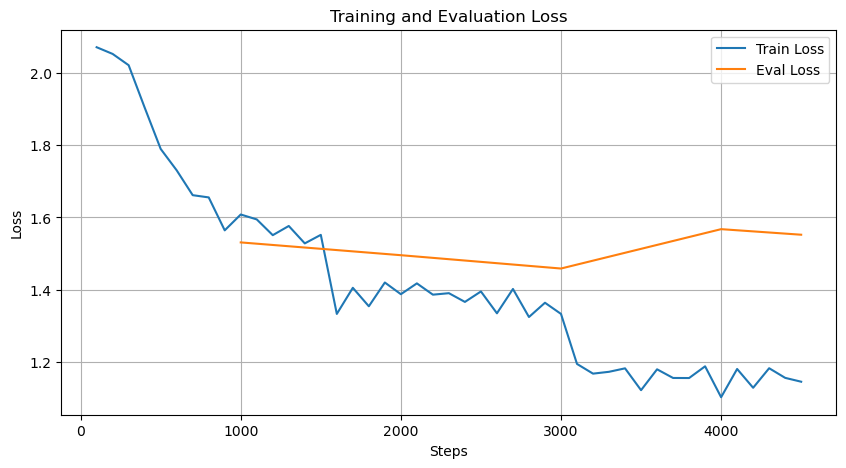

  0%|          | 0/750 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           1       0.55      0.43      0.48       708
           2       0.41      0.58      0.48       765
           3       0.88      0.84      0.86       245
           4       0.68      0.44      0.53       725
           5       0.38      0.54      0.45      1026
           6       0.32      0.31      0.31       853
           7       0.34      0.48      0.40       972
           8       0.00      0.00      0.00       706

    accuracy                           0.43      6000
   macro avg       0.44      0.45      0.44      6000
weighted avg       0.40      0.43      0.40      6000



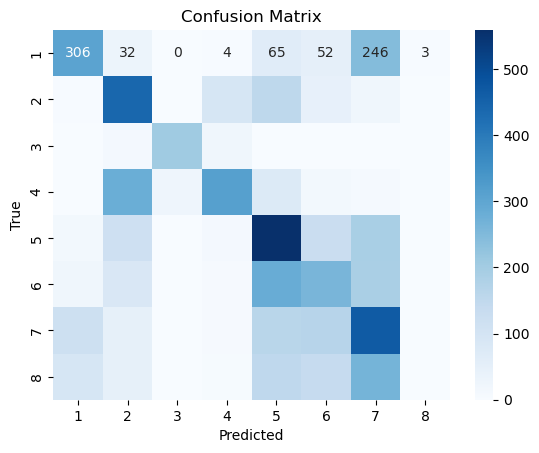

In [15]:
from sklearn.metrics import confusion_matrix, classification_report

final_evaluation = trainer.evaluate()

# ロスの履歴を取得
train_loss = []
train_steps = []
eval_loss = []
eval_steps = []
for log in trainer.state.log_history:
    if "loss" in log.keys():
        train_loss.append(log["loss"])
        train_steps.append(log["step"])
    if "eval_loss" in log.keys():
        eval_loss.append(log["eval_loss"])
        eval_steps.append(log["step"])

# 最後の評価結果を追加
eval_loss.append(final_evaluation["eval_loss"])
eval_steps.append(trainer.state.global_step)

# ロスのプロット
plt.figure(figsize=(10, 5))
plt.plot(train_steps, train_loss, label='Train Loss', color='C0')
plt.plot(eval_steps, eval_loss, label='Eval Loss', color='C1')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Evaluation Loss')
plt.grid(True)
plt.show()

predictions = trainer.predict(eval_dataset)
preds = np.argmax(predictions.predictions, axis=1)
#true_labels = eval_dataset["labels"]
# 分類レポートの生成
report = classification_report(test_label, preds, target_names=[str(i) for i in range(1, 9)])
print(report)

# 混同行列の計算
cm = confusion_matrix(test_label, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(1,9)], yticklabels=[str(i) for i in range(1,9)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### 同じ条件でデータ数３倍  
やはり性能向上した

  0%|          | 0/2250 [00:00<?, ?it/s]

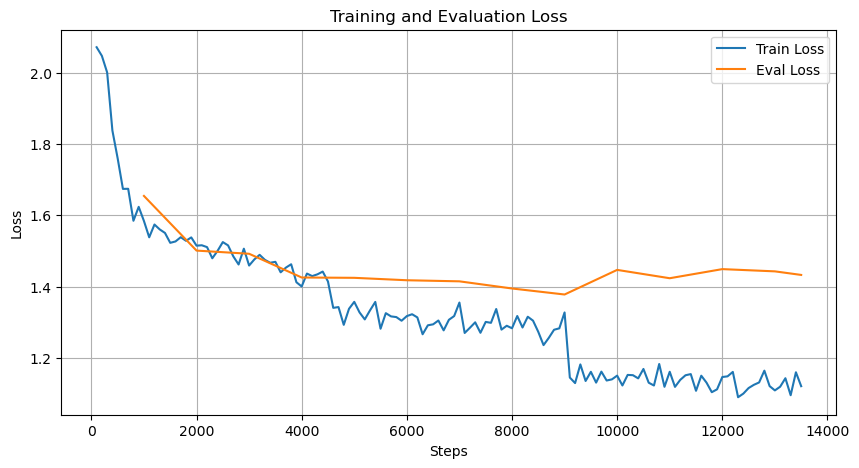

  0%|          | 0/2250 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           1       0.55      0.50      0.53      2195
           2       0.43      0.61      0.51      2223
           3       0.85      0.77      0.81       721
           4       0.67      0.58      0.62      2145
           5       0.42      0.57      0.48      2951
           6       0.40      0.33      0.36      2639
           7       0.41      0.48      0.44      2924
           8       0.23      0.08      0.11      2202

    accuracy                           0.47     18000
   macro avg       0.50      0.49      0.48     18000
weighted avg       0.46      0.47      0.45     18000



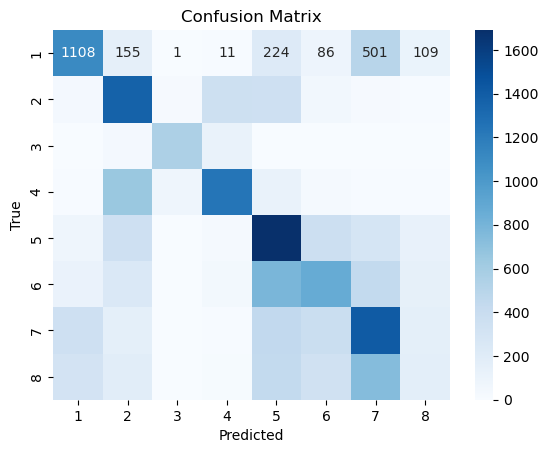

In [23]:
from sklearn.metrics import confusion_matrix, classification_report

final_evaluation = trainer.evaluate()

# ロスの履歴を取得
train_loss = []
train_steps = []
eval_loss = []
eval_steps = []
for log in trainer.state.log_history:
    if "loss" in log.keys():
        train_loss.append(log["loss"])
        train_steps.append(log["step"])
    if "eval_loss" in log.keys():
        eval_loss.append(log["eval_loss"])
        eval_steps.append(log["step"])

# 最後の評価結果を追加
eval_loss.append(final_evaluation["eval_loss"])
eval_steps.append(trainer.state.global_step)

# ロスのプロット
plt.figure(figsize=(10, 5))
plt.plot(train_steps, train_loss, label='Train Loss', color='C0')
plt.plot(eval_steps, eval_loss, label='Eval Loss', color='C1')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Evaluation Loss')
plt.grid(True)
plt.show()

predictions = trainer.predict(eval_dataset)
preds = np.argmax(predictions.predictions, axis=1)
#true_labels = eval_dataset["labels"]
# 分類レポートの生成
report = classification_report(test_label, preds, target_names=[str(i) for i in range(1, 9)])
print(report)

# 混同行列の計算
cm = confusion_matrix(test_label, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(1,9)], yticklabels=[str(i) for i in range(1,9)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()